# cifar-10 training, optimized

## koshy george, kgeorge2@gmail.com

'We use [tensorflow](https://www.tensorflow.org/) to train a convolutional neural net (CNN) net to classify [cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

We have already talked about taking the necessary baby steps to do the basic training using a simple AlexNet based moduel on cifar-10  in our initial [un-optimized implementation](tf_cifar.ipynb). The accuracy that we got from the simple implementation was only 75%. Here we are going to implement a number of optimization steps and see whether we can improve the accuracy.

As in the case of our [original implementation](tf_cifar.ipynb), we make use of custom ipython widgets to display the progress graph of training. Please check <code>common/utils.ipynb</code>.

### Requirements
We require [jupyter ipywidgets](https://github.com/ipython/ipywidgets) to be installed before running this notebook. [ipywidget](https://github.com/ipython/ipywidgets) is a small add-on to [jupyter](http://jupyter.org/) technology. You can easily pip install this component once you have installed [jupyter](http://jupyter.org/). 

*Before starting the server with '<code>jupyter notebook --ip=0.0.0.0</code>' we do the following command to ensure that ipywidgets are enabled in the notebook. '<code>jupyter nbextension enable --py widgetsnbextension</code>.'*


We implemented the following optimizations
* global contrast normalization.
* learning rate decay
* batch normakization
* dropout

As a result of this our validation accuracy increased to ![as shown below](comparison_opt.png)


Let us import <code>common/utils.ipynb</code> as a python module. We first amend <code>sys.path</code> to include the relative path which houses the <code>utils.ipynb</code> notebook. We also import the module <code> load_notebooks.ipynb</code> which helps us in loading <code>utils.ipynb</code>.

In [1]:
from __future__ import division, print_function, absolute_import
#mechanism to dynamically include the relative path where utils.ipynb is housed to the module search path.
from inspect import getsourcefile
import os
import os.path
import sys
import time
import re
import pickle
import urllib, tarfile
current_path = os.path.abspath(getsourcefile(lambda:0))
parent_dir = os.path.split(os.path.dirname(current_path))[0]
sys.path.insert(0, parent_dir)
#load_notebooks.py is a module which houses the mechanism to load other notebooks as a python module

import common.load_notebooks
import common.utils
import common.cifar_utils

importing Jupyter notebook from common/utils.ipynb


<IPython.core.display.Javascript object>

In [2]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Download the cifar data into the data-directory if needed.
The data directory is realtively positioned in this example as
    
    * this_notebook.ipynb
    * common
        * utils.ipynb
    * data
        * dataset_dir, possible place where the cifar-10-python directory is untarred


In [3]:
cifar_data = common.cifar_utils.CifarData();

dataset_dir = cifar_data.maybe_download_and_extract('./../data')
print(dataset_dir)

('Successfully downloaded', 'cifar-10-python.tar.gz', 170498071, 'bytes.')
./../data/cifar-10-batches-py


 Given below  are the hyper parameters and control parameters used. 

* We use cifar-10 which consist of images categorized into 10 classes. So <code>n_classes</code> = 10. 

* Our <code>batch_size</code>  which is the number of sample images in a mini-batch is 256. 

* The input images are 3-channel (RGB) images ech of size <code>image_depth x image_height x image_width</code>, where <code>image_height</code> = 32, <code>image_width</code> = 32 and <code>image_depth</code>=3. 

* Our <code>starting_learning_rate</code> is 0.05. 

* We use a <code>MomentumOptimizer</code>, with a momentum rate of 0.9. 

* Once we train all images in  the training set, we repeat the training for <code>n_epoch</code>, where <code>n_epoch</code>. 

* If epoch number <code>(0:n_epochs)</code> is divisible by <code>n_checkpoint_steps</code>, we save the checkpoint.

In [4]:
class HyperParams(object):
    def __init__(self):
        self.n_classes=10
        self.batch_size=256
        self.image_width=32
        self.image_height=32
        self.image_depth=3
        self.starting_learning_rate=0.05
        
        
class ControlParams(object):
    def __init__(self):
        self.n_epochs=2000
        self.n_checkpoint_steps=5
    

class DatasetParams(object):
    def __init__(self, dataset_dir=dataset_dir):
        self.n_validate_samples=2000
        self.n_test_samples=5
        self.dataset_dir=dataset_dir
        self.checkpt_dir=DatasetParams.compute_checkpt_dir(dataset_dir)
        
    def get_final_checkpt_acc_plot(self):
        dataset_name = os.path.split(dataset_dir)[1]
        return os.path.join(self.checkpt_dir, 'out_imgs', '%s_acc_final.pkl' % dataset_name)
    
    @staticmethod
    def compute_checkpt_dir(dataset_dir):
        checkpt_dir = os.path.join(dataset_dir, 'chkpt_cifar10')
        if not os.path.isdir(checkpt_dir):
            os.makedirs(checkpt_dir)
        return checkpt_dir
    
hyper_params=HyperParams()
control_params=ControlParams()
dataset_params=DatasetParams()



#### global contrast-normalization (GCN)
After loading the image data, we do not employ any dynamic data-augmentation (which can prevent overfitting). We do not crop the images to any smaller size.  The only transformation that we do is mean-normalization (global contrast normalization) per image. Please take a look at <code>common/utils/cifar_utils.py, CifarData.prepare_input_ </code>.

At the end of the loading of data and labels from the dataset, we expect the following

*  <code>train_all['data']</code> is an <code>numpy</code> ndarray of <code>dtype=numpy.float32</code> and  shape <code>(N_train, h, w, d)</code>, where <code>N_train</code>=number of images  in the training set, <code>h=image_height, w=image_width</code> and <code>d=image_depth</code>.

*  <code>train_all['labels']</code> is an <code>numpy</code> ndarray of <code>dtype=numpy.int32</code> and  shape = <code>(N_train,)</code>

*  <code>validate_all['data']</code> is an <code>numpy</code> ndarray of <code>dtype=numpy.float32</code> and  shape <code>(N_validate, h, w, d)</code>, where <code>N_validate</code>=number of images  used for validating, <code>h=image_height, w=image_width</code> and <code>d=image_depth</code>.

*  <code>validate_all['labels']</code> is an <code>numpy</code> ndarray of <code>dtype=numpy.int32</code> and  <code>shape = (N_validate,)</code>
*  <code>N_validate = n_validate_samples</code>, (ie 2000) only the first 2000 images in the test set is used for validation.
* <code>train_all['data']</code>  and <code>validate_all['data']</code>  are GCN-ed per image.






In [5]:
cifar_data.load_and_preprocess_input(
    dataset_dir=dataset_params.dataset_dir, 
    n_validate_samples=dataset_params.n_validate_samples, 
    n_test_samples=dataset_params.n_test_samples)

('train: data:  shape=(50000, 32, 32, 3)  , dtype=float32, labels: shape=(50000,), dtype=int32',)
('validate: data:  shape=(2000, 32, 32, 3)  , dtype=float32, labels: shape=(2000,), dtype=int32',)
('test: data:  shape=(5, 32, 32, 3)  , dtype=float32, labels: shape=(5,), dtype=int32',)
("label names for images used ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']",)


<code>init_weights</code> is a handy function that constructs a  tensorflow Variable from a set of parameters. We can use this to construct, weights and biases for our network used.

<code>wireup</code> accepts the data <code>X</code> as a placeholder and wire-up the model (neural net), returning the variable which is the final output.(logits)

<code>compute_loss</compute> computes the cross-entropy between the logits and the label-data

Compared with the original [unoptimized code](tf_cifar.ipynb), during wire-up we emply sereveral optimization steps.

#### dropout
The first two of the three final fully connected layers each have a dropout layer attached, the dropout control parameter is determined by the placeolder <code>keep_prob</code>.

#### batch normailzation
We removed the biases from the first two convolutional layers and replaced with a batch-normalization layer.


In [6]:

#kg: handy general initialization function
#
def init_weights(shape, init_method='xavier', seed=42, xavier_params = (None, None), const=0.0,  name='', stddev=0.05):
    assert(name)
    if init_method=='constant':
        return tf.get_variable(name, shape, initializer=tf.constant_initializer(const), dtype=tf.float32)
    elif init_method == 'uniform':
        return tf.Variable(tf.random_normal(shape, stddev=stddev, dtype=tf.float32, seed=seed), name=name)
    elif init_method == 'tnormal':
        return tf.get_variable(name, shape,  dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32, seed=seed))
        #return tf.Variable(, name=name)
    elif init_method=='xavier':
        (fan_in, fan_out) = xavier_params
        low = -4*np.sqrt(6.0/(fan_in + fan_out))
        high = 4*np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32, seed=seed), name=name)

#base class for the model    
class Net(object):
    def __init__(self, batch_size=-1, n_classes=-1, scope='dummy'):
        assert(batch_size >=0)
        assert(n_classes > 0)
        self.batch_size=batch_size
        self.n_output=n_classes
        self.weights_initializer_method='tnormal'
        self.scope=scope
        
    def wireup(self, placeholder_x=None, placeholder_dropout_control=None):
        raise RuntimeError ('not implemented!')
        
#derived class for the model
class Net_with_BN(Net):
    def __init__(self, *args, **kwds):
        super(Net_with_BN, self).__init__(*args, **kwds)
        self.batch_norm_fudge_epsilon=1.0e-3
        
    def wireup(self, placeholder_x=None, placeholder_dropout_control=None):
        with tf.variable_scope(self.scope) as sc:
            #first convolutional layer
            nin=3
            nout=64
            c1 = init_weights(shape=[5,5,nin, nout], init_method=self.weights_initializer_method, name='c1')
            conv1 = tf.nn.conv2d(placeholder_x, c1, strides=[1,1,1,1], padding='SAME')
            batch_mean1, batch_var1 = tf.nn.moments(conv1,[0])
            conv1_hat = (conv1 - batch_mean1)/tf.sqrt(batch_var1 + self.batch_norm_fudge_epsilon)
            # Create two new parameters, scale and beta (shift)
            scale1 = tf.Variable(tf.ones([nout]))
            beta1 = tf.Variable(tf.zeros([nout]))
            BN1 = scale1 * conv1_hat + beta1
            BN1 = tf.nn.relu(BN1)
            
            pool1 = tf.nn.max_pool(BN1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')
            norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm1')
    
    
            #second convolutional layer
            c2 = init_weights(shape=[5,5,64, 64], init_method=self.weights_initializer_method, name='c2')
            conv2 = tf.nn.conv2d(norm1, c2, strides=[1,1,1,1], padding='SAME')
            batch_mean2, batch_var2 = tf.nn.moments(conv2,[0])
            conv2_hat = (conv2 - batch_mean2)/tf.sqrt(batch_var2 + self.batch_norm_fudge_epsilon)
            # Create two new parameters, scale and beta (shift)
            scale2 = tf.Variable(tf.ones([nout]))
            beta2 = tf.Variable(tf.zeros([nout]))
            BN2 = scale2 * conv2_hat + beta2
            BN2 = tf.nn.relu(BN2)
     
            norm2 = tf.nn.lrn(BN2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm2')
            pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool2')
    
            reshape = tf.reshape(pool2, [self.batch_size, -1])
            dim = reshape.get_shape()[1].value
        
            #first fully connected layer
            fc1= init_weights(shape=[dim, 768], init_method=self.weights_initializer_method, name='fc1')
            bc1= init_weights(shape=[768], init_method='constant', name='bc1', const=0.1)
            full1 = tf.nn.relu(tf.matmul(reshape, fc1) + bc1, name='full1')
            full1 = tf.nn.dropout(full1, placeholder_dropout_control)
        
            #second fully connected layer
            fc2= init_weights(shape=[768, 384], init_method=self.weights_initializer_method, name='fc2')
            bc2= init_weights(shape=[384], init_method='constant', name='bc2', const=0.1)
            full2 = tf.nn.relu(tf.matmul(full1, fc2) + bc2, name='full2')
            full2 = tf.nn.dropout(full2, placeholder_dropout_control)
        
            #output layer       
            last = init_weights(shape=[384, self.n_output], init_method=self.weights_initializer_method, name='last')
            b_last = init_weights(shape=[self.n_output], init_method='constant', name='b_last')
            logits = tf.add(tf.matmul(full2, last), b_last, name='final')
        return logits



def compute_loss(logits, labels):
    print('compute_loss: {lg}, {lb}'.format(lg=logits.get_shape(), lb=labels.get_shape()))
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
      logits, labels, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    return cross_entropy_mean
    
    

#### GUI support for progress display
For displaying progress as an incrementally updating matplotlib plot, we employ several instances of the  custom [ipywidget](https://github.com/ipython/ipywidgets) , defined at <code>common/utils.ipynb</code> called <code>ProgressImageWidget</code>. We enclose all progress image widgets in a top-level  <code>widgets.VBox</code>. Please check with the implementation of the <code>ProgressImageWidget</code> at <code>common/utils.ipynb</code>


We also have  a stop button for stopping eth training upon which the training is gracefully shutdown and a checkpoint information is written.





In [7]:
from IPython.display import display
import ipywidgets as widgets
bContinueTraining=True
p_loss=common.utils.ProgressImageWidget()
p_acc=common.utils.ProgressImageWidget()
p_stop=widgets.Button(description='Stop')

def on_button_clicked(b):
    global bContinueTraining
    print('stop training')
    bContinueTraining=False

    
p_stop.on_click(on_button_clicked)
top_level=widgets.VBox(children=[p_loss, p_acc,  p_stop])



#for displaying the training loss
plotter_loss = common.utils.Plotter(xlabel='no. of epochs', ylabel='loss', title='epochs')
plotter_loss.add_channel(num_samples=control_params.n_epochs, channel_name='train_loss', legend='train_loss')

#for displaying the training and validation accuracy, in the sample plot
plotter_acc = common.utils.Plotter(xlabel='no. of epochs', ylabel='acc', title='epochs')
plotter_acc.add_channel(num_samples=control_params.n_epochs, channel_name='train_acc',legend='train_acc')
plotter_acc.add_channel(num_samples=control_params.n_epochs, channel_name='validate_acc', legend='validate_acc')


#### Learning rate decay

We implement a decaying schedule for the learning rate by the step,
<code>
learning_rate = tf.train.exponential_decay(hyper_params.starting_learning_rate, global_step,5000, 0.96, staircase=True)
</code>

Every 5000 mini-batch iteration, we set the current learning rate as the previous learning rate * 0.96.

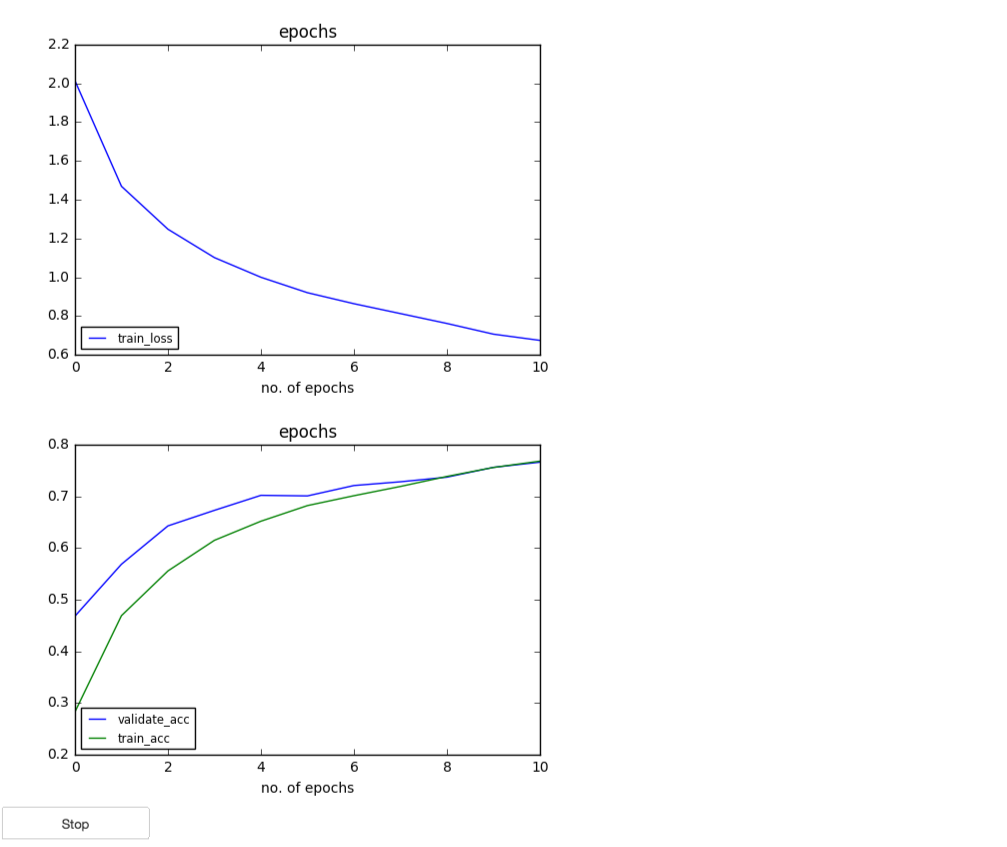

compute_loss: (256, 10), (256, 10)
starting training
loss for global_step 975, epoch 4, train_loss=0.999729003967,  validate-accuracy=0.702008928571,  time=47.2853000164
loss for global_step 1950, epoch 9, train_loss=0.706071564173,  validate-accuracy=0.756138392857,  time=47.3308031559
stop training
stopped training
done training
testing 5 images
test_image: automobile  top-5 matches ['frog', 'deer', 'bird', 'cat', 'dog']
test_image: dog  top-5 matches ['frog', 'cat', 'deer', 'dog', 'bird']
test_image: deer  top-5 matches ['truck', 'frog', 'bird', 'ship', 'automobile']
test_image: dog  top-5 matches ['frog', 'cat', 'deer', 'bird', 'dog']
test_image: horse  top-5 matches ['dog', 'cat', 'frog', 'bird', 'deer']
done testing


In [8]:
display(top_level)

with tf.Graph().as_default():
    #params
    global hyper_params, control_params, dataset_params
    
    #placeholders
    is_train = tf.placeholder(tf.bool)
    X = tf.placeholder(tf.float32, 
                       shape=(hyper_params.batch_size, hyper_params.image_height, hyper_params.image_width, hyper_params.image_depth))
    y = tf.placeholder(tf.float32, shape=(hyper_params.batch_size, hyper_params.n_classes))    
    keep_prob = tf.placeholder(tf.float32)
    
    #variables
    global_step = tf.Variable(0, trainable=False)
    net=Net_with_BN(batch_size=hyper_params.batch_size, n_classes=hyper_params.n_classes)
    logits=net.wireup(placeholder_x=X, placeholder_dropout_control=keep_prob)
    #logits=wireup_bn(X, keep_prob, batch_size=batch_size, n_classes=10, scope='train')
    loss = compute_loss(logits, y)
    
    #exponentually decaying learing rate.
    learning_rate = tf.train.exponential_decay(hyper_params.starting_learning_rate, global_step,5000, 0.96, staircase=True)
   
    #learning_rate = tf.train.exponential_decay(hyper_params.starting_learning_rate, global_step,5000,0.96, staircase=True)
    optimizer=tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss,global_step) 
    train_prediction = tf.nn.softmax(logits)
    accuracy_1 = tf.equal(tf.argmax(train_prediction, 1), tf.argmax(y, 1))
    accuracy=tf.reduce_mean(tf.cast(accuracy_1,tf.float32),0)
    _, top_k_pred = tf.nn.top_k(logits, k=5)
    init = tf.initialize_all_variables()
    saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)
    
    n_batches_train = int(cifar_data.train_dataset['labels'].shape[0]//hyper_params.batch_size)
    n_batches_validate = int(cifar_data.validate_dataset['labels'].shape[0]//hyper_params.batch_size)
    
    def checkpoint(g, plotter_loss, plotter_acc, is_final=False):
        dataset_name = os.path.split(dataset_params.dataset_dir)[1]
        if not os.path.isdir(os.path.join(dataset_params.checkpt_dir, 'out_imgs')):
            os.makedirs(os.path.join(dataset_params.checkpt_dir, 'out_imgs'))
        loss_fig_path= os.path.join(dataset_params.checkpt_dir, 'out_imgs', '%s_train_loss.png' % dataset_name)
        acc_fig_path= os.path.join(dataset_params.checkpt_dir, 'out_imgs', '%s_acc.png' % dataset_name)
        acc_plot = os.path.join(dataset_params.checkpt_dir, 'out_imgs', '%s_acc.pkl' % dataset_name)
        if is_final:
            acc_plot = dataset_params.get_final_checkpt_acc_plot()
            #os.path.join(dataset_params.checkpt_dir, 'out_imgs', '%s_acc_final.pkl' % dataset_name)
            
        plotter_loss.plot_and_save_fig(savepath=loss_fig_path)
        plotter_acc.plot_and_save_fig(savepath=acc_fig_path)
        
        with file(acc_plot, 'wb') as fp:
            pickle.dump(plotter_acc, fp, pickle.HIGHEST_PROTOCOL)
        
        with file(acc_plot, 'rb') as fp:
            plotter_acc = pickle.load(fp)
        
        saver.save(sess, os.path.join(dataset_params.checkpt_dir, 'train_cifar10.ckpt'),
                           global_step=g)
        return plotter_loss, plotter_acc
        
    def all_batches_run_train(n_batches, data=None, labels=None):
        sum_all_batches_loss =0
        sum_all_batches_acc=0
        sum_n_samples=0
        is_train=True
        for b in xrange(n_batches):            
                offset = b * hyper_params.batch_size
                batch_data = data[offset : offset+hyper_params.batch_size, :, :, :]
                n_samples = batch_data.shape[0]
                batch_labels = labels[offset: offset + hyper_params.batch_size]
                batch_labels = (np.arange(hyper_params.n_classes) == batch_labels[:, None]).astype(np.float32)
                feed_dict = {X: batch_data, 
                             y: batch_labels,
                             keep_prob:0.5}
                _, loss_value, a =sess.run([optimizer, loss, accuracy], feed_dict=feed_dict)
                sum_all_batches_loss += loss_value * n_samples
                sum_all_batches_acc += a * n_samples
                sum_n_samples += n_samples
                if(n_samples != hyper_params.batch_size):
                    print('n_samples =%d' % n_samples)
        return (sum_all_batches_loss/sum_n_samples, sum_all_batches_acc/sum_n_samples)
    
    def all_batches_run_validate(n_batches, data=None, labels=None):
        sum_all_batches_acc=0
        sum_n_samples=0
        is_train=False
        for b in xrange(n_batches):
                offset = b * hyper_params.batch_size
                batch_data = data[offset : offset+ hyper_params.batch_size, :, :, :]
                n_samples = batch_data.shape[0]
                batch_labels = labels[offset: offset+ hyper_params.batch_size]
                batch_labels = (np.arange(hyper_params.n_classes) == batch_labels[:, None]).astype(np.float32)
                feed_dict = {X: batch_data, 
                             y: batch_labels,
                            keep_prob:1.0}
                a, top_k = sess.run([accuracy, top_k_pred], feed_dict=feed_dict)
                sum_all_batches_acc += a * n_samples
                sum_n_samples += n_samples
                if(n_samples != hyper_params.batch_size):
                    print('n_samples =%d' % n_samples)
        return sum_all_batches_acc/sum_n_samples
    
    
    def run_test(data=None, labels=None):
        is_train=False
        assert(data.shape[0] == labels.shape[0])
        batch_data = np.zeros(shape=(hyper_params.batch_size, data.shape[1], data.shape[2], data.shape[3]), dtype=np.float32)
        batch_labels= np.zeros(shape=(hyper_params.batch_size), dtype=np.int32)
        batch_data[0:data.shape[0], : , :, :] = data[:, :, :, :]
        batch_labels[0:data.shape[0],] = labels[:]
        batch_labels = (np.arange(hyper_params.n_classes) == batch_labels[:, None]).astype(np.float32)
        feed_dict = {X: batch_data, y: batch_labels, keep_prob:1.0}
        a, top_k = sess.run([accuracy, top_k_pred], feed_dict=feed_dict)
        print('testing %r images' % dataset_params.n_test_samples)
        for i in range(dataset_params.n_test_samples):
            print('test_image: %s' % cifar_data.label_names_for_validation_and_test[ cifar_data.test_dataset['labels'][i]], 
                  ' top-5 matches %r'%[ cifar_data.label_names_for_validation_and_test[j] for j in top_k[i]])
            
    with tf.Session() as sess:
        sess.run(init)
        print('starting training')
        
        for e in xrange(control_params.n_epochs):
            
            if not bContinueTraining:
                print('stopped training')
                break
                
            get_ipython().kernel.do_one_iteration()
            
            start_time = time.time()
            n_data = cifar_data.train_dataset['data'].shape[0]
            
            perm = np.random.permutation(n_data)
            permuted_data = cifar_data.train_dataset['data'][perm,:, :, :]
            permuted_labels = cifar_data.train_dataset['labels'][perm]
            
            validate_data = cifar_data.validate_dataset['data']
            validate_labels = cifar_data.validate_dataset['labels']
            
            mean_loss_per_sample_train, accuracy_per_sample_train =all_batches_run_train(n_batches_train, data=permuted_data, labels=permuted_labels)
            accuracy_per_sample_validate=all_batches_run_validate(n_batches_validate, data=validate_data, labels=validate_labels)
     
            plotter_loss.add_sample( e, mean_loss_per_sample_train , channel_name='train_loss')
            plotter_acc.add_sample( e, accuracy_per_sample_train, channel_name='train_acc')
            plotter_acc.add_sample( e, accuracy_per_sample_validate, channel_name='validate_acc')
            
            p_loss.value = plotter_loss.plot()
            p_acc.value = plotter_acc.plot()
            duration = time.time() - start_time
            if ((e+1)% control_params.n_checkpoint_steps) == 0:
                print('loss for global_step {g}, epoch {e}, train_loss={l},  validate-accuracy={a},  time={t}'.format(g=global_step.eval(), e=e, l=mean_loss_per_sample_train, a=accuracy_per_sample_validate, t=duration))
                plotter_loss, plotter_acc = checkpoint(global_step.eval(), plotter_loss, plotter_acc ,is_final=False)
        print('done training')
        plotter_loss, plotter_acc = checkpoint(global_step.eval(), plotter_loss, plotter_acc, is_final=True)
        run_test(data=cifar_data.test_dataset['data'], labels=cifar_data.test_dataset['labels'])
        print('done testing')